<a href="https://colab.research.google.com/github/Yolantele/ML-data-clasifier/blob/master/NL_SpaCy_ML_Classifier_for_Waste_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### NL_SpaCy_ML_Classifier_for_Waste_Data_Augmentation

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install -U spacy
!pip install pandas
!python -m spacy download nl_core_news_md

     |████████████████████████████████| 10.0MB 2.7MB/s 
     |████████████████████████████████| 2.1MB 44.9MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


     |████████████████████████████████| 46.5MB 1.2MB/s 
  Created wheel for nl-core-news-md: filename=nl_core_news_md-2.3.0-cp36-none-any.whl size=46591694 sha256=aa891a22b7bda3ce259a526d8c50b000fa6d7ea7bfd962014e573500a9df8999
  Stored in directory: /tmp/pip-ephem-wheel-cache-qn65em0s/wheels/97/0b/2c/fca80722197f454a1b012af6aa0116362d4cb6b6f3efef09e9
Successfully built nl-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('nl_core_news_md')


In [7]:
import spacy
import pandas as pd
from spacy.lang.nl import Dutch
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin

# References:
# skLearn + Spacy -------> https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/
# Eural Code reference --> https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX:02000D0532-20150601

import nl_core_news_md
spacy.prefer_gpu()

nlp = nl_core_news_md.load

In [6]:
path = '/content/drive/My Drive/data/'
materials = pd.read_csv(path + '/nlMaterialData.csv')
# or use test data frame where material field is empty
materials_test = pd.read_csv(path + '/nlWithoutMaterialData.csv')

df = materials # change to materials_test for no material assigned
df.head()
# df.info()
# df.description + df.euralDescription
# df.description + df.euralDescription


,reason,origin,color,state,size,consistency,otherCode,material4,material3,material2,material,mType,composite2,composite1,cType,indirectProduct,directProduct,pType,mixedOrPure,cleanOrDirty,euralDescription,euralCode,description,/0
0,afgekeurd,NaN,NaN,NaN,NaN,vast,NaN,NaN,NaN,NaN,organisch materiaal,NaN,NaN,GFT,NaN,GFT,NaN,NaN,gemengd,NaN,afval van dierlijke weefsels,20102,GFT Afgekeurd,NaN
1,NaN,NaN,NaN,NaN,NaN,vast,categorie 3,NaN,NaN,NaN,organisch materiaal,NaN,NaN,GFT,NaN,GFT,NaN,NaN,puur,NaN,afval van dierlijke weefsels,20102,GFT Categorie 3,NaN
2,NaN,NaN,NaN,NaN,NaN,vast,200,NaN,NaN,NaN,hout,stobben,NaN,NaN,NaN,hout,NaN,NaN,puur,NaN,afval van plantaardige weefsels,20103,200 Boomstobben,NaN
3,NaN,NaN,NaN,NaN,NaN,vast,NaN,NaN,NaN,NaN,gras,bermgras,NaN,NaN,NaN,gras,NaN,NaN,puur,NaN,afval van plantaardige weefsels,20103,BERMGRAS,NaN
4,NaN,NaN,NaN,NaN,NaN,vast,NaN,NaN,NaN,NaN,organisch materiaal,blauwmaanzaad,NaN,NaN,NaN,organisch materiaal,NaN,NaN,puur,NaN,afval van plantaardige weefsels,20103,BLAUWMAANZAAD TER VERNIETIGING,NaN


###Tokening the Data With spaCy

create a custom tokenizer function using spaCy. We’ll use this function to automatically strip information we don’t need, like stopwords and punctuation, from each review.

In [8]:
parser = Dutch()
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

def spacy_tokenize(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    sentence = sentence.strip().lower()
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens


###**Vectorization Feature Engineering, TF-IDF, Bag of Words and N-grams**

Classifying text we end up with text snippets with their respective labels. But in machine learning model we need to convert into numeric representation (vector coordinates)

- **TF-IDF -Term Frequency-Inverse Document Frequency**- simply a way of normalizing our Bag of Words(BoW) by looking at each word’s frequency in comparison to the document frequency.

- **N-grams** - combinations of adjacent words in a given text. For example "who will win"
 1. when n = 1, becomes "who", "will", "win",
 2. when n = 2 , becomes "who will", "will win" etc. 

In [9]:
#bag of words vector
bow_vector = CountVectorizer(tokenizer=spacy_tokenize, ngram_range=(1,1))
print(bow_vector)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenize at 0x7f607477af28>,
                vocabulary=None)


In [10]:
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenize)
print(tfidf_vector)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenize at 0x7f607477af28>,
                use_idf=True, vocabulary=None)


### Splitting The Data into Training and Validation Sets


In [11]:
from sklearn.model_selection import train_test_split

X = df['description'] # the features we want to analyze
ylabels = df['material'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

print(X)

0                                           GFT Afgekeurd
1                                         GFT Categorie 3
2                                         200 Boomstobben
3                                                BERMGRAS
4                          BLAUWMAANZAAD TER VERNIETIGING
                              ...                        
3695                                          fruitresten
3696                             gft vloeibare reststrome
3697            consumptie ongeschikt mat. (palmvetzuren)
3698                                              zetmeel
3699    voedings-en genotmiddelen ongeschikt voor cons...
Name: description, Length: 3700, dtype: object


### Creating a Pipeline and Generating the Model

In [12]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Creating Logistic Regression Classifier
classifier = LogisticRegression()

# Create pipeline using Bag of Words (BoW)
model = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f60744004a8>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenize at 0x7f607477af28>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
             

#### **Predictions - Model Classifications**

In [14]:
from sklearn import metrics

row = 133

# Predicting for a test dataset
predicted = model.predict(X_test)


print('material description was ----> ', X_test.iloc[row])
print('material predicted is ----->', predicted[row])

material description was ---->  Uitbest: B hout, niet route
material predicted is -----> hout


In [16]:

# Model Accuracy Reports

print("Accuracy:",metrics.accuracy_score(y_test, predicted ))
print("Precision:",metrics.precision_score(y_test, predicted, average='weighted'))
print("Recall:",metrics.recall_score(y_test, predicted, average='weighted'))
print( metrics.classification_report(y_test, predicted))

Accuracy: 0.7738738738738739
Precision: 0.8056354151848608
Recall: 0.7738738738738739
                     precision    recall  f1-score   support

                ABS       0.00      0.00      0.00         1
        AVI-bodemas       0.00      0.00      0.00         1
                EPS       1.00      0.50      0.67        10
               HDPE       1.00      0.75      0.86         4
               LDPE       1.00      1.00      1.00        11
                OPP       0.00      0.00      0.00         1
                 PC       0.00      0.00      0.00         3
                 PE       1.00      0.50      0.67         2
                PET       0.00      0.00      0.00         1
                POM       0.00      0.00      0.00         1
                 PP       1.00      0.88      0.93         8
                 PS       1.00      1.00      1.00         4
                PVC       1.00      1.00      1.00        10
                RVS       0.67      0.50      0.57         

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Plotting the Classification Outcomes (description and material dependencies)**

UFuncTypeError: ignored

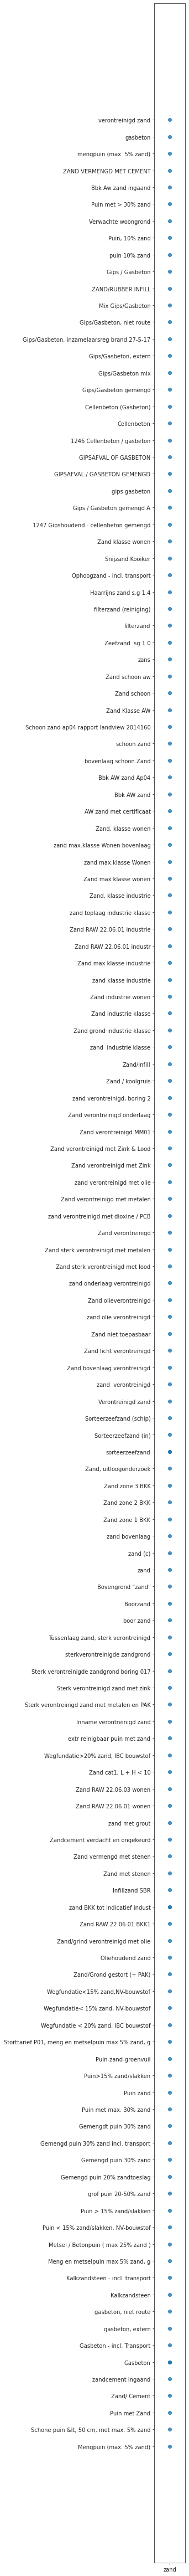

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


chosen_material = 'zand'

data = df.loc[df.material ==chosen_material]
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(1, 85)
sns.regplot(x='material', y='description', data=data, ax=ax)
